In [1]:
import pandas as pd

c:\Users\hp\anaconda3\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv('shopping_trends.csv')

# RFM Analysis

Our dataset doesn't have a date column, so will modify our analysis to only include Frequency (F) and Monetary (M) metrics.

In [3]:
df['Frequency'] = df['Previous Purchases'] + 1  
rfm = df.groupby('Customer ID').agg({
    'Frequency': 'sum', 
    'Purchase Amount (USD)': 'sum'  
}).rename(columns={'Purchase Amount (USD)': 'Monetary'})

print(rfm.head())


             Frequency  Monetary
Customer ID                     
1                   15        53
2                    3        64
3                   24        73
4                   50        90
5                   32        49


In [4]:
# Function to assign scores
def rfm_score(data, column, ascending=True):
    return pd.qcut(data[column], q=5, labels=range(5, 0, -1) if ascending else range(1, 6))

# Assign scores
rfm['F_Score'] = rfm_score(rfm, 'Frequency')
rfm['M_Score'] = rfm_score(rfm, 'Monetary')

# Combine F and M scores into a single FM_Score
rfm['FM_Score'] = rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

print(rfm.head())


             Frequency  Monetary F_Score M_Score FM_Score
Customer ID                                              
1                   15        53       4       3       43
2                    3        64       5       3       53
3                   24        73       3       2       32
4                   50        90       1       1       11
5                   32        49       2       4       24


In [5]:
# Define customer segments based on FM scores
def segment_customer(row):
    if row['F_Score'] == 5 and row['M_Score'] == 5:
        return 'Top Spenders'
    elif row['F_Score'] >= 4:
        return 'Frequent Buyers'
    elif row['M_Score'] >= 4:
        return 'High Value'
    else:
        return 'Other'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)


print(rfm.groupby('Segment').size())


Segment
Frequent Buyers    1409
High Value          948
Other              1391
Top Spenders        152
dtype: int64


In [6]:
from sklearn.preprocessing import StandardScaler

# Normalize Frequency and Monetary
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm[['Frequency', 'Monetary']])


In [16]:
from sklearn.cluster import KMeans

# Fit K-Means model
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_normalized)


In [13]:
print(rfm.dtypes)

Frequency       int64
Monetary        int64
F_Score      category
M_Score      category
FM_Score       object
Segment        object
Cluster         int32
dtype: object


In [15]:
# Select only numeric columns
numeric_rfm = rfm[['Frequency', 'Monetary', 'Cluster']]

# Group by Cluster and calculate the mean
cluster_summary = numeric_rfm.groupby('Cluster').mean()

print(cluster_summary)


         Frequency   Monetary
Cluster                      
0        39.306039  80.270215
1        38.320000  38.973333
2        13.944676  80.771399
3        13.785859  39.675758


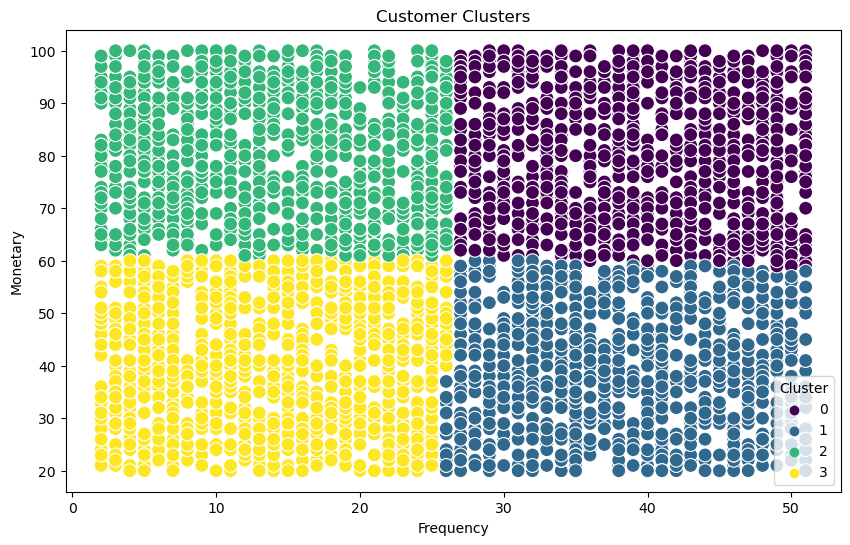

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatterplot of clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=rfm['Frequency'], y=rfm['Monetary'], hue=rfm['Cluster'], palette='viridis', s=100)
plt.title('Customer Clusters')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()


This visualization provides a general idea about the diversity in customer behavior based on how frequently they make purchases (Frequency) and how much they spend (Monetary). Here's what we can infer about your customers as a whole:

## 1. Customer Segmentation Exists
The presence of distinct clusters indicates that our customer base is not uniform. Customers naturally fall into different behavioral groups.

## 2. Key Patterns Observed
### High Spenders (Green):
Some customers spend a lot despite making purchases less frequently. They might represent a premium customer segment or those who make big, occasional purchases.
### Frequent Buyers (Purple): 
Others shop often but tend to spend less per transaction. They might represent budget-conscious or loyal customers who repeatedly engage with the store.
### Balanced Shoppers (Blue): 
A middle-ground group exists with moderate spending and frequency, likely forming a core customer base.
### Low Activity Customers (Yellow): 
A group with low frequency and spending, possibly representing new customers, disengaged customers, or those at risk of churn.

## 3. Business Implications

### Opportunities to Target Specific Segments:

Cluster 2 (Green): We can try to engage these high spenders with premium offers or loyalty programs to maintain their interest.

Cluster 0 (Purple): Encourage these frequent buyers to spend more through upselling or bundling offers.

Cluster 1 (Blue): Strengthen the relationship with this balanced group as they could represent long-term, stable customers.

Cluster 3 (Yellow): Work on reactivating these low activity customers through targeted campaigns.

### Resource Allocation:
Helps us focus marketing efforts and promotions effectively, spending resources on high-value or at-risk groups.

### Takeaway:
The visualization reveals that our customer base is composed of diverse behavioral types, suggesting opportunities for tailored marketing and retention strategies. It also highlights areas for growth (e.g., increasing frequency among high spenders or boosting spending for frequent buyers).
